<a href="https://colab.research.google.com/github/nguyen084/MATH5671/blob/master/MATH_5671_group_005_assignment_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance Purchase Prediction Using Deep Neural Network

In this notebook a deep neural network is used using tf.keras.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

os.chdir(r'/content/gdrive/My Drive/Academic/UCONN/Financial Research/MATH5671/')
insurance_df = pd.read_csv("training_data.csv",header =0)
insurance_df.head()

,STATE,REGION,SEX,PROFESSION,AGE,HAS_CHILDREN,SALARY,N_OF_DEPENDENTS,CAR_OWNERSHIP,HOUSE_OWNERSHIP,TIME_AS_CUSTOMER,MARITAL_STATUS,CREDIT_BALANCE,BANK_FUNDS,CHECKING_AMOUNT,MONEY_MONTLY_OVERDRAWN,T_AMOUNT_AUTOM_PAYMENTS,MONTHLY_CHECKS_WRITTEN,MORTGAGE_AMOUNT,N_TRANS_ATM,N_MORTGAGES,N_TRANS_TELLER,CREDIT_CARD_LIMITS,N_TRANS_KIOSK,N_TRANS_WEB_BANK,LTV,LTV_BIN,BUY_INSURANCE
0,CA,West,M,IT Staff,63,0,59461,0,1,0,2,SINGLE,0,0,25,53.06,504,0,0,0,0,0,900,2,0,22165.25,HIGH,0
1,CA,West,M,PROF-9,36,1,60271,1,1,1,1,DIVORCED,0,2900,25,54.51,1311,3,3063,5,1,1,900,0,3063,22167.75,HIGH,1
2,FL,South,M,Programmer/Developer,21,0,64738,3,1,0,3,SINGLE,0,500,25,53.02,539,4,0,2,0,2,1000,4,0,13784.50,LOW,1
3,WA,West,F,IT Staff,47,1,65071,1,1,1,1,OTHER,56297,12500,25,57.70,59437,17,15000,6,1,7,500,3,3000,24467.75,HIGH,1
4,UT,Southwest,M,Technical Writer,26,0,61674,3,1,1,3,SINGLE,0,0,25,53.06,0,0,300,0,1,0,1500,5,300,23518.50,HIGH,0


## Data Exploration
Exploring the dataset using plots, histograms, descriptive statistics, etc.

In [0]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# target variable distribution
insurance_df.groupby(['BUY_INSURANCE'])[['BUY_INSURANCE']].count()

,BUY_INSURANCE
BUY_INSURANCE,
0,529
1,181


Let's take a look at the correlation matrix

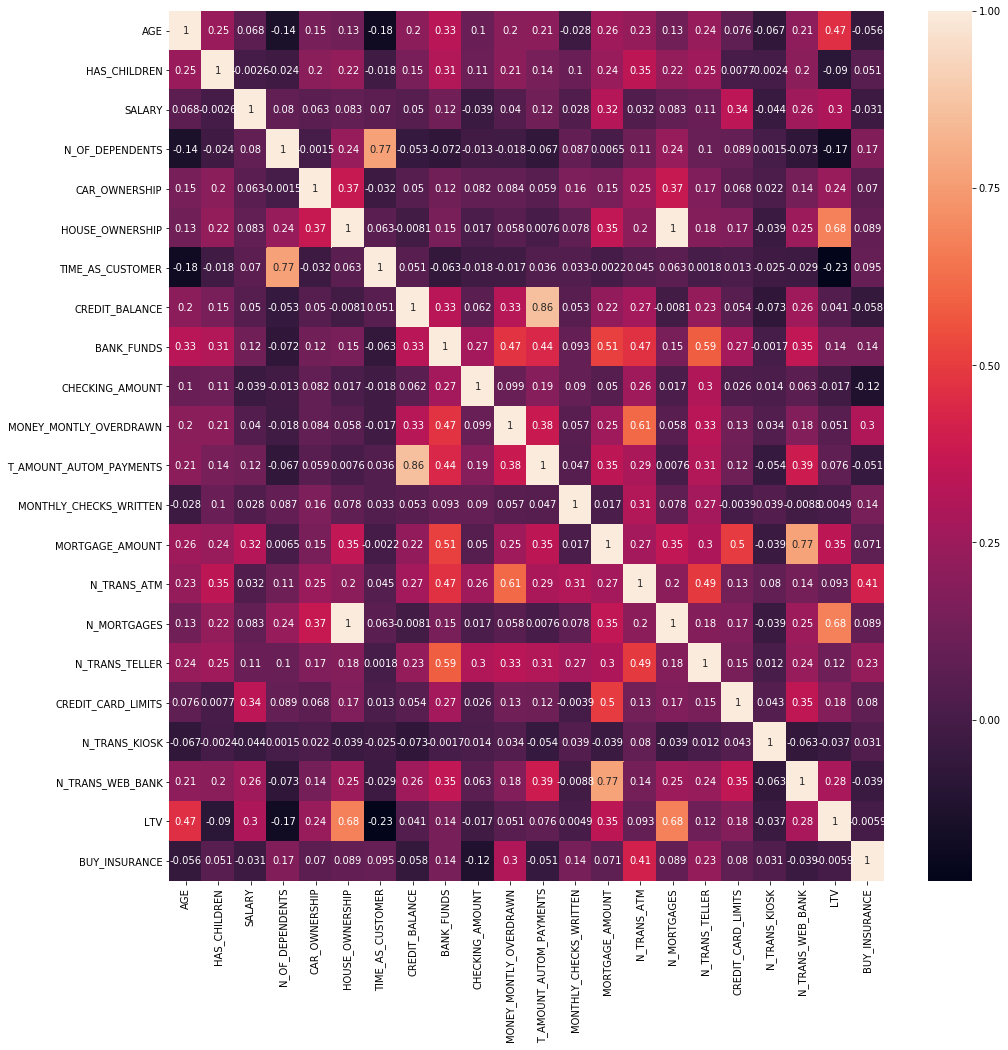

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = insurance_df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Preprocessing
Convert a number of categorical variables to dummy variables

In [0]:
# convert categorical variables to dummy variables
cat_vars=['STATE','REGION','SEX','PROFESSION','MARITAL_STATUS']
cat_df = pd.get_dummies(insurance_df[cat_vars], prefix='var')
insurance_df = pd.concat([insurance_df,cat_df],axis = 1) # concat horizontally with newly dummy features

In [0]:
# remove the original categorical variables
data_vars = insurance_df.columns.values.tolist()
selected_columns = list(set(data_vars).difference(set(cat_vars)))
# np.array(selected_columns)

# now only get variables after converting to dummy variables
data = insurance_df[selected_columns]
data.head()

,MONEY_MONTLY_OVERDRAWN,MONTHLY_CHECKS_WRITTEN,AGE,var_PROF-29,var_PROF-20,var_DBA,CREDIT_BALANCE,N_MORTGAGES,var_Administrator,var_PROF-4,var_OH,LTV,var_F,var_Fireman,TIME_AS_CUSTOMER,var_UT,var_PROF-2,T_AMOUNT_AUTOM_PAYMENTS,var_Mason,var_IL,BANK_FUNDS,var_PROF-57,var_PROF-55,var_NorthEast,N_TRANS_WEB_BANK,BUY_INSURANCE,var_Nurse,var_PROF-11,var_PROF-51,var_AK,var_PROF-60,var_PROF-40,var_PROF-22,var_OK,var_PROF-47,var_PROF-61,var_TX,var_PROF-26,var_PROF-6,N_TRANS_KIOSK,...,var_PROF-33,var_PROF-36,var_PROF-18,var_WIDOWED,var_PROF-7,var_South,var_Bank Teller,LTV_BIN,var_PROF-34,var_PROF-48,var_PROF-9,var_OR,var_NY,var_Southwest,var_PROF-14,var_Construction Laborer,var_PROF-30,var_PROF-3,CAR_OWNERSHIP,var_Medical Doctor,var_PROF-5,var_PROF-12,var_MARRIED,var_Law Enforcement Officer,var_PROF-52,var_PROF-59,var_PROF-56,var_Accountant,var_PROF-21,var_DIVORCED,var_Plumber,N_OF_DEPENDENTS,var_PROF-54,N_TRANS_ATM,var_Programmer/Developer,var_Clerical,var_PROF-41,var_PROF-13,var_PROF-8,var_Midwest
0,53.06,0,63,0,0,0,0,0,0,0,0,22165.25,0,0,2,0,0,504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,HIGH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,54.51,3,36,0,0,0,0,1,0,0,0,22167.75,0,0,1,0,0,1311,0,0,2900,0,0,0,3063,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,HIGH,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,5,0,0,0,0,0,0
2,53.02,4,21,0,0,0,0,0,0,0,0,13784.50,0,0,3,0,0,539,0,0,500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,1,0,LOW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,1,0,0,0,0,0
3,57.70,17,47,0,0,0,56297,1,0,0,0,24467.75,1,0,1,0,0,59437,0,0,12500,0,0,0,3000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,HIGH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,0,0,0,0,0,0
4,53.06,0,26,0,0,0,0,1,0,0,0,23518.50,0,0,3,1,0,0,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,HIGH,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0


Simply set a threshold on the correlation with the target variable

In [0]:
# Simple thresholds
relevant_features = []
for col in data.columns:
    thres = 0.1
    try:
        corr = data['BUY_INSURANCE'].corr(data[col])
    except:
        print(col)
        
    if abs(corr) > thres:
        relevant_features.append(col)
    
relevant_features

LTV_BIN


['MONEY_MONTLY_OVERDRAWN',
 'MONTHLY_CHECKS_WRITTEN',
 'var_F',
 'BANK_FUNDS',
 'BUY_INSURANCE',
 'var_Nurse',
 'N_TRANS_TELLER',
 'CHECKING_AMOUNT',
 'var_M',
 'var_SINGLE',
 'var_NC',
 'var_DIVORCED',
 'N_OF_DEPENDENTS',
 'N_TRANS_ATM',
 'var_Programmer/Developer',
 'var_PROF-8']

In [0]:
data = data[relevant_features]

In [0]:
from sklearn.model_selection import train_test_split
X = data[data.columns.difference(['BUY_INSURANCE','LTV_BIN'])]

In [0]:
# Min-max scaling. Not really necessary for NN, but a must if using any distance measure
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = data[['BUY_INSURANCE']].values.astype('float64')

This is an unbalance data set so we use imblearn to under/over-sample the data set. 

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)
X_resampled, y_resampled = shuffle(X_resampled, y_resampled)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Now the class distribution is balanced

In [0]:
y_train_df= pd.DataFrame(data=y_resampled,columns=['BUY_INSURANCE'])
y_train_df.groupby(['BUY_INSURANCE'])[['BUY_INSURANCE']].count()

,BUY_INSURANCE
BUY_INSURANCE,
0.0,118
1.0,118


## Training, Validation, and Testing

In [0]:
def display_scores(scores): 
    print("Scores:", scores) 
    print("Mean:", scores.mean()) 
    print("Standard deviation:", scores.std())

If you use TensorBoard then start it as below, specifying the root log directory you used above. Wait a few seconds for TensorBoard's UI to spin up. You may see TensorBoard display the message "No dashboards are active for the current data set". That's because initial logging data hasn't been saved yet. As training progresses, the Keras model will start logging data. TensorBoard will periodically refresh and show you your scalar metrics. If you're impatient, you can tap the Refresh arrow at the top right

Now training, check back the tensorboard to see the charts (if use Tensorboard)

In [0]:
# Sequential API
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from datetime import datetime

input_dim = len(X_resampled[0])
output_dim = 1
nodes = 200
layers = 5

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10) 
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir)

model = Sequential()
model.add(Dropout(0.1, input_shape=(input_dim,))) # dropout regularization

for i in range(layers):
    model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
    
model.add(Dense(output_dim, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#history = model.fit(X_resampled, y_resampled, epochs=100, batch_size=20, verbose=0, validation_split=0.2)
history = model.fit(X_resampled, y_resampled, epochs=100, batch_size=20, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb, tensorboard_cb]) # Use this line if want to try Tensorboard

In [0]:
# Scores for training and validation set
print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

0.8031915
0.75


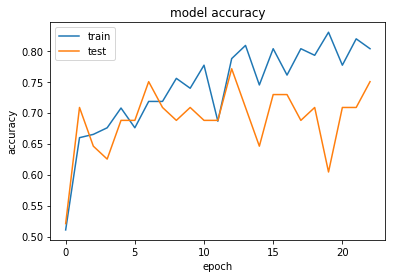

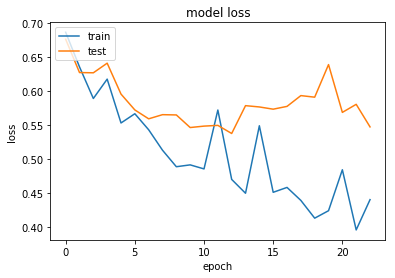

In [0]:
# plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plotting history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Have a look at the loss and accuracy. If validation is close to training would mean not overfitting. If overfitting, will need to adjust regularization, feature selection,...

(0, 1)

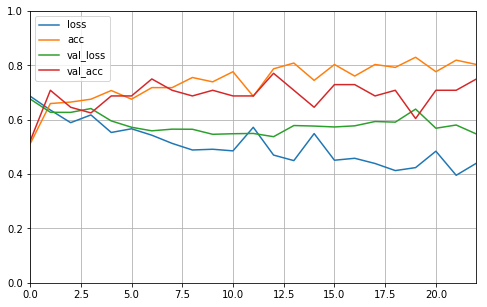

In [0]:
#Another way of viewing loss/accuracy using pandas
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

Model evaluation using the test set: loss and accuracy 

In [0]:
model.evaluate(X_test, y_test)

213/213 [==============================] - 0s 178us/sample - loss: 0.6812 - acc: 0.6901


[0.6812399186438798, 0.69014084]

In [0]:
y_test_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix = confusion_matrix(y_test, y_test_pred.round())
print(confusion_matrix)
print(classification_report(y_test, y_test_pred.round()))

[[93 57]
 [ 9 54]]
              precision    recall  f1-score   support

         0.0       0.91      0.62      0.74       150
         1.0       0.49      0.86      0.62        63

    accuracy                           0.69       213
   macro avg       0.70      0.74      0.68       213
weighted avg       0.79      0.69      0.70       213



We use a split for validation previously. Let's also try K-fold cross validation: 1 for validation and K-1 folds for training (specified using cv parameter). cross_val_score() return scores for the validation sets, and compare with validation split result

However we would want to train many variant models and choose the best one, so we would use Grid Search or Randomized Search. Parameter grid may have multiple hyperparameters. Note that if the best parameter value is at either ends, should continue searching past the ends.

## Your work

Starting here write your own neural network code. To train, use X_resampled and y_resampled. To test, use X_test, y_test. Compute the accuracy, confusion matrix, precision, recall. Start with writing individual functions, then the main code that calls the functions above to train a model using the training data and return theta, then test the model using the test data, compute accuracy, confusion matrix, precision, recall

In [0]:
# Source: https://github.com/SSQ/Coursera-Ng-Neural-Networks-and-Deep-Learning/tree/master/Week%204%20PA%201
#The model is derived from Andrew Ng's coursera courses, but we just need to add regulazation into the cost funtions.
import numpy as np
import math
from sklearn import preprocessing
# Should use the same training/test datasets above: X_resampled, y_resampled, X_test_os, y_test_os

  
# function that normalizes each predictor

def normalize(X):
    Xnorm=np.linalg.norm(X, ord=1)
    if Xnorm==0:
        Xnorm=np.finfo(X.dtype).eps
    return X/Xnorm
  
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-1.0 * z))
  
def initialize_parameters(n_x, n_h, n_y):
  #Create weights and bias for each layer
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
  
def forward_propagation(X, parameters):

    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #Tanh activation the first layer and sigmoid for the second layer
    Z1 = np.add(np.matmul(W1, X), b1)
    A1 = np.tanh(Z1)
    Z2 = np.add(np.matmul(W2, A1), b2)
    A2 = sigmoid(Z2)   
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache
  
def computeCost(A2, Y, parameters, lambd):
    m = Y.shape[1] # number of example
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Compute the cross-entropy cost
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply((1 - Y), np.log(1 - A2))
    cross_entropy_cost = (-1.0/m) * np.sum(logprobs)
    
    # Compute regularization cost
    L2_regularization_cost = (np.sum(np.square(W1)) + np.sum(np.square(W2)))*(lambd/(2*m))
    
    # add cross_entropy_cost and regularization_cost
    cost = cross_entropy_cost + L2_regularization_cost
    
    # makes sure cost is the dimension we expect. 
    cost = np.squeeze(cost)
    return cost
  
def computeGrad(X, Y, cache, parameters, lambd):
    #Compute grad using back propogation
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. Add the regularization term to dW2,dW1
    dZ2 = A2 - Y
    dW2 = (1.0/m) * np.matmul(dZ2, np.transpose(A1)) + (lambd/m)*W2 ## add the regularization term
    db2 = (1.0/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.matmul(np.transpose(W2), dZ2) * (1 - np.power(A1, 2))
    dW1 = (1.0/m) * np.matmul(dZ1, np.transpose(X)) + (lambd/m)*W1 ## add the regularization
    db1 = (1.0/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
  
def gradient(parameters, grads, learning_rate = 1.2):
    #Updates parameters using the gradient descent update rule given above
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
  
def optimize(X, Y, n_h, num_iterations = 10000, learning_rate=1.2, print_cost=False, lambd = 0.7):
    #run the neural network upto n iterations
    n_x = X.shape[0]
    n_y = Y.shape[0]
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #X = normalize(X)
    # Loop (gradient descent)
    costs = []
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        #A2 = normalize(A2) #normalize the weight during the traning
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = computeCost(A2, Y, parameters, lambd)
        costs.append(cost)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = computeGrad(X, Y, cache, parameters, lambd)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = gradient(parameters, grads, learning_rate=learning_rate)
        
        # cache all about model
        trained_model = {
            "layer_sizes": (n_x, n_h, n_y),
            "learning_rate": learning_rate,
            "costs": costs,
            "parameters": parameters
        }

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return trained_model
  
def predict(parameters, X):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)

    return predictions

In [0]:
y = optimize(X_train.T, y_train.T, 5, num_iterations = 40000, learning_rate=0.05, print_cost=True, lambd = 1.2)

Cost after iteration 0: 0.693119
Cost after iteration 1000: 0.509267
Cost after iteration 2000: 0.419678
Cost after iteration 3000: 0.405555
Cost after iteration 4000: 0.403409
Cost after iteration 5000: 0.402778
Cost after iteration 6000: 0.402476
Cost after iteration 7000: 0.402276
Cost after iteration 8000: 0.402109
Cost after iteration 9000: 0.401950
Cost after iteration 10000: 0.401791
Cost after iteration 11000: 0.401628
Cost after iteration 12000: 0.401462
Cost after iteration 13000: 0.401293
Cost after iteration 14000: 0.401122
Cost after iteration 15000: 0.400948
Cost after iteration 16000: 0.400774
Cost after iteration 17000: 0.400602
Cost after iteration 18000: 0.400433
Cost after iteration 19000: 0.400269
Cost after iteration 20000: 0.400109
Cost after iteration 21000: 0.399953
Cost after iteration 22000: 0.399798
Cost after iteration 23000: 0.399642
Cost after iteration 24000: 0.399480
Cost after iteration 25000: 0.399309
Cost after iteration 26000: 0.399125
Cost after ite

Text(0.5, 1.0, 'Cost function using Gradient Descent')

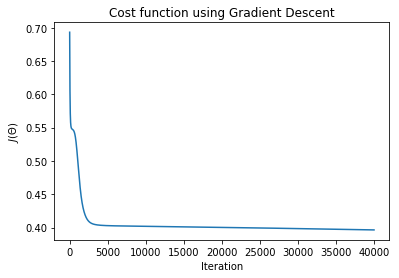

In [0]:
plt.plot(y['costs'])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
#Plot show the convergence of of the model

In [0]:
pred = predict(y['parameters'],X_test.T)

In [0]:
print('\nVal Accuracy: '+ str(np.mean((pred == y_test.T) * 100)))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#These are the accuracy and confusion matrix for training set
confusion_matrix_train = confusion_matrix(y_test.T.ravel(), pred.ravel())
print(confusion_matrix_train)
print(classification_report(y_test, pred.round().T))


Val Accuracy: 78.87323943661971
[[141   9]
 [ 36  27]]
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86       150
         1.0       0.75      0.43      0.55        63

    accuracy                           0.79       213
   macro avg       0.77      0.68      0.70       213
weighted avg       0.78      0.79      0.77       213



## Scoring the leaderboard

Use your model to score the test feature dataset in the Insurance Purchase Prediction project/contest below. After joining the practice project, you can create a team and invite members. Submit your score result to see how it is ranked, and share your notebook/write-up.

http://www.scriptedin.com/contests/view/6

Now going through the same preprocessing step above for the test dataset

In [0]:
test_feature_df = pd.read_csv("test_features.csv",header =0)
test_feature_df.head()

# convert categorical variables to dummy variables
cat_vars=['STATE','REGION','SEX','PROFESSION','MARITAL_STATUS']
cat_list = pd.get_dummies(test_feature_df[cat_vars], prefix='var')
test_feature_df=pd.concat([test_feature_df,cat_list],axis = 1) # concat horizontally with newly dummy features

Reindexing the dataset. This is because the number of columns/variables are different. Filling zero in. 

In [0]:
transformed_cols = insurance_df.columns
test_feature_df = test_feature_df.reindex(columns = transformed_cols.difference(['BUY_INSURANCE']), fill_value=0)

Now remove the original categorical variables. You don't use them to train the model.

In [0]:
# remove the original categorical variables
data_vars=test_feature_df.columns.values.tolist()
selected_columns = list(set(data_vars).difference(set(cat_vars)))
np.array(selected_columns)

# now only get variables after converting to dummy variables
test_data = test_feature_df[selected_columns]
test_data.shape

(305, 147)

In [0]:
test_data.head()

,MONEY_MONTLY_OVERDRAWN,MONTHLY_CHECKS_WRITTEN,AGE,var_PROF-29,var_PROF-20,var_DBA,CREDIT_BALANCE,N_MORTGAGES,var_Administrator,var_PROF-4,var_OH,LTV,var_F,var_Fireman,TIME_AS_CUSTOMER,var_PROF-2,var_UT,T_AMOUNT_AUTOM_PAYMENTS,var_Mason,var_IL,BANK_FUNDS,var_PROF-57,var_PROF-55,var_NorthEast,N_TRANS_WEB_BANK,var_PROF-11,var_Nurse,var_PROF-51,var_AK,var_PROF-60,var_PROF-40,var_PROF-22,var_OK,var_PROF-47,var_PROF-61,var_TX,var_PROF-26,var_PROF-6,N_TRANS_KIOSK,var_Administrative Assistant,...,var_PROF-33,var_PROF-36,var_PROF-18,var_WIDOWED,var_PROF-7,var_South,var_Bank Teller,LTV_BIN,var_PROF-34,var_PROF-48,var_PROF-9,var_OR,var_NY,var_Southwest,var_PROF-14,var_Construction Laborer,var_PROF-30,var_PROF-3,CAR_OWNERSHIP,var_Medical Doctor,var_PROF-5,var_PROF-12,var_MARRIED,var_Law Enforcement Officer,var_PROF-52,var_PROF-59,var_PROF-56,var_Accountant,var_PROF-21,var_DIVORCED,var_Plumber,N_OF_DEPENDENTS,var_PROF-54,N_TRANS_ATM,var_Programmer/Developer,var_Clerical,var_PROF-41,var_PROF-13,var_PROF-8,var_Midwest
0,53.06,0,21,0,0,0,0,1,0,0,0,17067.00,1,0,5,0,0,0,0,1,0,0,0,0,1500,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,MEDIUM,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1
1,53.20,18,50,0,0,0,0,1,0,0,0,31303.50,1,0,1,0,0,1159,0,0,450,0,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,VERY HIGH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0
2,55.41,2,65,0,0,0,0,1,0,0,0,24097.25,1,0,4,0,0,2826,0,0,3200,0,0,0,400,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,...,0,0,0,0,0,1,0,HIGH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3,0,5,0,0,0,0,0,0
3,53.45,4,42,0,0,0,0,1,0,0,0,24318.25,0,0,1,0,0,1364,0,1,2950,0,0,0,550,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,HIGH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,4,0,0,0,0,0,1
4,53.22,9,27,0,0,0,0,0,0,0,0,13127.50,0,0,3,0,0,268,0,0,700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,LOW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,1,0,0,0,0,0


Also remove some variables. 

In [0]:
relevant_features.remove('BUY_INSURANCE')

In [0]:
relevant_features.remove('LTV_BIN')

ValueError: ignored

In [0]:
X_test_more = test_data[relevant_features]
X_test_more.shape

(305, 15)

Min-max scaling

In [0]:
# Min-max scaling. 
# XX and y are array/list

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_test_more = scaler.fit_transform(X_test_more)
X_test_more.shape

(305, 15)

In [0]:
pred_test = predict(y['parameters'],X_test_more.T)

In [0]:
pred_test.ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Now have some fun. Assuming My_y_pred is the predicted result as a list. Export the result to a csv file as follows. The first column is numbered starting from 1;The second is the label of the prediction. The first row is the header. Submit the csv to the project at https://www.scriptedin.com/contests/view/6 via Add Submission to see where you are on the leaderboard

In [0]:
pd.DataFrame(list(zip(list(range(1, len(pred_test.ravel()) + 1)),pred_test.ravel())), columns=['num','label']).to_csv(r'/content/gdrive/My Drive/Academic/UCONN/Financial Research/MATH5671/submission.csv', index=None, header=True)
#got 73%